This project is designed to take in a dataset of 5000 text messages and create a model that can identify key phrases between spam and ham text messages. The program will then label it as a 1 for spam or 0 for ham (non spam text message) and a report will be created on the performance of the model.

The Dataset used is provided by Kaggle 
https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset


In [ ]:
import os
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve,confusion_matrix,auc
from sklearn.svm import SVC

import matplotlib.pyplot as plt

from google.colab import drive

Calls libary functions and imports them for use later on

In [ ]:
# Mount your Google Drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Read SMS message dataset

df = pd.read_csv("gdrive/MyDrive/Khilnani_LP_spam_detection_data.csv", encoding='ISO-8859-1')

# df is the call name for the SMS message dataset
# Print the first three indexs of the dataset

df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [ ]:
# Start splitting the information and labeling

# Y will hold an array of labelling information with 1 or 0 based on if there is "spam" in column "v1"
y = np.array([(1 if i=='spam' else 0) for i in df.v1.tolist()])

# X will hold an array of the text message sample in column "v2"
X = np.array(df.v2.tolist())

# Import SuffleSplit function
from sklearn.model_selection import StratifiedShuffleSplit

# Take StratifiedShuffleSplit takes in number of splits, and creates a test size of %30 of the total data set size with a 
splitter = StratifiedShuffleSplit(
    n_splits=1, test_size=0.3, random_state=0
)

# splits the two arrays by each index into a training index and test index based on the splitter parameters 
# X holds a text message string at each index
# Y holds a boolean value of 0 (ham) or 1 (spam)
for train_index, test_index in splitter.split(X, y):
    #stores the values at each indexes in X array into a train and test declared for pre_vectorization
    X_train_pre_vectorize, X_test_pre_vectorize = X[train_index], X[test_index]
    #stores the values at each indexes in y array into a train and test
    y_train, y_test = y[train_index], y[test_index]

In [ ]:
#y[0:10], x[0:10]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Sets vectorizer for the function of CountVectorizer after importing it from sklearn lib.
vectorizer = CountVectorizer()

# vectorizer to fit infomration from the X_train_pre_vectorize and sets them into an array that each index corrosponds to a word and in that index the intger is frequency of the word
X_train = vectorizer.fit_transform(X_train_pre_vectorize)
X_test = vectorizer.transform(X_test_pre_vectorize)

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [ ]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, neg_label=0, pos_label=1, classes=[0,1])

y_test_bin = np.hstack((1 - y_test_bin, y_test_bin))
print(y_test_bin)

[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in [0,1]:
    # collect labels and scores for the current index
    labels = y_test_bin[:, i]
    scores = y_score[:, i]
    
    # calculates FPR and TPR for a number of thresholds
    fpr[i], tpr[i], thresholds = roc_curve(labels, scores)
    
    # given points on a curve, this calculates the area under it
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr["micro"], tpr["micro"])

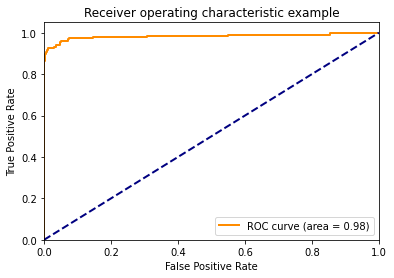

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# PART 2 OF SPAM SMS.

In [ ]:
y_score = classifier.predict_proba(X_test)
y_score = np.array(y_score)
print(y_score)

[[0.99499553 0.00500447]
 [0.9935737  0.0064263 ]
 [0.99582628 0.00417372]
 ...
 [0.99459692 0.00540308]
 [0.99258867 0.00741133]
 [0.98905956 0.01094044]]


In [ ]:
#creating two separate dfs: 1 for spam and 1 for non spam messages only
df_s = df.loc[ df['target']==1]
df_ns = df.loc[ df['target']==0]
    
df_s['len'] = [len(x) for x in df_s["text"]]
spamavg = df_s.len.mean()
print('df_s.head(5)')
print(df_s.head(5))

print('\n\ndf_ns.head(5)')
df_ns['len'] = [len(x) for x in df_ns["text"]]
nonspamavg = df_ns.len.mean()
print(df_ns.head(5))



df_s.head(5)
                                                 text  target  len
1   Free entry in 2 a wkly comp to win FA Cup fina...       1  155
4   FreeMsg Hey there darling it's been 3 week's n...       1  150
7   WINNER!! As a valued network customer you have...       1  160
8   Had your mobile 11 months or more? U R entitle...       1  154
10  SIX chances to win CASH! From 100 to 20,000 po...       1  136


df_ns.head(5)
                                                text  target  len
0                      Ok lar... Joking wif u oni...       0   29
2  U dun say so early hor... U c already then say...       0   49
3  Nah I don't think he goes to usf, he lives aro...       0   61
5  Even my brother is not like to speak with me. ...       0   77
6  As per your request 'Melle Melle (Oru Minnamin...       0  160


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
spamavg

140.02008032128515

In [ ]:
nonspamavg

71.71621061359868

In [ ]:
df['length'] = df['text'].apply(lambda x: len(''.join([a for a in x if a.isdigit()])))

print(np.mean(df['length'][df['target'] == 0]), np.mean(df['length'][df['target'] == 1]))

print(df.head(10))

0.30534825870646765 15.812583668005354
                                                text  target  length
0                      Ok lar... Joking wif u oni...       0       0
1  Free entry in 2 a wkly comp to win FA Cup fina...       1      25
2  U dun say so early hor... U c already then say...       0       0
3  Nah I don't think he goes to usf, he lives aro...       0       0
4  FreeMsg Hey there darling it's been 3 week's n...       1       4
5  Even my brother is not like to speak with me. ...       0       0
6  As per your request 'Melle Melle (Oru Minnamin...       0       1
7  WINNER!! As a valued network customer you have...       1      19
8  Had your mobile 11 months or more? U R entitle...       1      13
9  I'm gonna be home soon and i don't want to tal...       0       0


In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], random_state=0)

In [ ]:
#fitting and transforming X_train using a Count Vectorizer with default parameters
vect = CountVectorizer().fit(X_train)
X_train_vectorized = vect.transform(X_train)

In [ ]:
vect

CountVectorizer()

In [ ]:
X_train_vectorized

<4178x7414 sparse matrix of type '<class 'numpy.int64'>'
	with 55380 stored elements in Compressed Sparse Row format>

In [ ]:
#fitting a multinomial Naive Bayes Classifier Model with smoothing alpha=0.1
model = sklearn.naive_bayes.MultinomialNB(alpha=0.1)
model_fit = model.fit(X_train_vectorized, y_train)

In [ ]:
#making predictions & looking at AUC score
predictions = model.predict(vect.transform(X_test))
aucscore = roc_auc_score(y_test, predictions) #good!
aucscore

0.9615532083312719

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(pd.DataFrame(confusion_matrix(y_test, predictions),
             columns=['Predicted Spam', "Predicted Ham"], index=['Actual Spam', 'Actual Ham']))

print(f'\nTrue Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

tpr = (tp / (tp + fn))
fpr = (fp / (fp + tn))

print(f'\nTrue Positive Rate: { (tp / (tp + fn))}')
print(f'Specificity: { (tn / (tn + fp))}')
print(f'False Positive Rate: { (fp / (fp + tn))}')



             Predicted Spam  Predicted Ham
Actual Spam            1185              4
Actual Ham               15            189

True Positives: 189
False Positives: 4
True Negatives: 1185
False Negatives: 15

True Positive Rate: 0.9264705882352942
Specificity: 0.9966358284272497
False Positive Rate: 0.00336417157275021


In [ ]:
def roc_curve_plot(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
#https://towardsdatascience.com/lets-learn-about-the-roc-auc-curve-by-predicting-spam-d8007746a6f9
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_score = classifier.predict_proba(X_test)
y_score = np.array(y_score)
print(y_score)

ValueError: ignored

In [ ]:
print(fpr)
print(tpr)

fprmatrix = np.asmatrix(fpr)
print(fprmatrix)
tprmatrix = np.asmatrix(tpr)
print(tprmatrix)

roc_auc = auc(fprmatrix, tprmatrix)
roc_curve_plot(fpr, tpr, roc_auc)

0.00336417157275021
0.9264705882352942
[[0.00336417]]
[[0.92647059]]


ValueError: ignored